In [1]:
import random
from random import sample
import numpy as np
import pandas as pd
from scipy import stats

import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE, MDS
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [ ]:
# альтернативный способ кодирования кат фичей
# https://github.com/art-glazunov/Non-standard-categorical-encodings/blob/main/LSA_encoding.ipynb

In [2]:
dataset = pd.read_csv('../data/cat_num.csv')
dataset.sample()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
51574,77.37.246.177,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_1 like ...,447,200,REQUEST_ARGS_KEYS,#flash_close,#flash_close,AVdnBq_eq1Ppo9zF8eB9


In [ ]:
cat_features = list(dataset.loc[:, dataset.dtypes == object].columns)

In [50]:
dataset[cat_features].sample()

,CLIENT_USERAGENT,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
9375,Mozilla/5.0 (compatible; AhrefsBot/5.2; +http:...,REQUEST_GET_ARGS,REQUEST_GET_ARGS.id,79335,O4z9IGQB5cBXmMW1IRId


In [2]:
def categorical_to_texts(data):
  """Transform categorical data rows into texts as follows:
  “Var1Name_Value1 Var2Name_Value2 …”
  """
  new_data_list = []
  columns = list(data.columns)
  for line in tqdm(data.values):
    new_line = ''
    for pair in zip(columns, line):
      new_line = new_line + f'{pair[0]}_{pair[1]} '
    new_data_list.append(new_line)
  return new_data_list

In [41]:
dataset_cat_to_texts = categorical_to_texts(dataset[cat_features])

  0%|          | 0/57829 [00:00<?, ?it/s]

In [42]:
vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=10,max_df=0.2)
bow_matrix = vectorizer.fit_transform(dataset_cat_to_texts)
bow_matrix.shape

(57829, 11296)

In [43]:
def vect2gensim(vectorizer, dtmatrix):
    """ transform sparse matrix into gensim corpus and dictionary """
    corpus_vect_gensim = gensim.matutils.Sparse2Corpus(dtmatrix, documents_columns=False)
    dictionary = gensim.corpora.dictionary.Dictionary.from_corpus(corpus_vect_gensim,
        id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))

    return (corpus_vect_gensim, dictionary)
     
(gensim_corpus, gensim_dict) = vect2gensim(vectorizer, bow_matrix)
     
# bow_matrix_test = vectorizer.transform(X_test_texts)
# gensim_corpus_test,_ = vect2gensim(vectorizer, bow_matrix_test)

def get_topic_vectors(model,corpus):
  """Get new features form the topic LSA model and gensim corpus"""
  num_topics = len(model[corpus[1]])
  doc_vectors = np.zeros((len(corpus), num_topics))
  for i, doc in enumerate(tqdm(corpus)):
    topics = model[doc]
    for pair in topics:
      j = pair[0]
      doc_vectors[i,j] = pair[1]
  return doc_vectors

In [44]:
%%time
lsamodel = gensim.models.LsiModel(gensim_corpus, num_topics=700, id2word = gensim_dict, power_iters=30)
lsa_features = get_topic_vectors(lsamodel, gensim_corpus)

  0%|          | 0/57829 [00:00<?, ?it/s]

CPU times: user 18min 50s, sys: 31.1 s, total: 19min 21s
Wall time: 3min 23s


In [46]:
lsa_features

array([[ 2.64525473e-02,  5.27587321e-02,  5.09536512e-02, ...,
         2.43016889e-02,  5.20200001e-03, -1.24968204e-02],
       [ 1.46786264e+00, -6.81445490e-04, -3.01240742e-02, ...,
        -2.79991467e-02,  4.93892388e-02, -5.49429387e-02],
       [ 2.90572796e-02,  6.57088818e-02, -1.51531616e-02, ...,
         1.32703817e-02, -3.04747820e-02,  1.47485379e-02],
       ...,
       [ 6.65019930e-02,  7.69577044e-02,  2.31050191e-03, ...,
         2.88955335e-02,  2.05771061e-02,  4.70968849e-02],
       [ 8.07503343e-02,  4.16245121e-02, -2.46695628e-02, ...,
        -5.67056050e-02, -6.61597540e-02, -6.37100606e-02],
       [ 3.21703006e-02,  7.84962143e-02,  5.22508893e-02, ...,
        -8.94108535e-03, -6.49244148e-03, -1.99991975e-02]])

In [45]:
# TODO: сохранить 
# for col in cat_features:
#     dataset[col + '_count'] = dataset[col].map(dataset.groupby(col).size())

# num_features = list(set(dataset.columns).difference(set(cat_features)))
# num_features.append('CLIENT_IP')
# len(num_features)

13

In [ ]:
# dataset[num_features].to_csv('../data/gensim_embeddings.csv', index=False)

In [47]:
%%time
scaler = StandardScaler()
scaled_emb = scaler.fit_transform(lsa_features)

CPU times: user 225 ms, sys: 79.7 ms, total: 305 ms
Wall time: 312 ms


CPU times: user 57min 47s, sys: 5min 49s, total: 1h 3min 36s
Wall time: 8min 54s


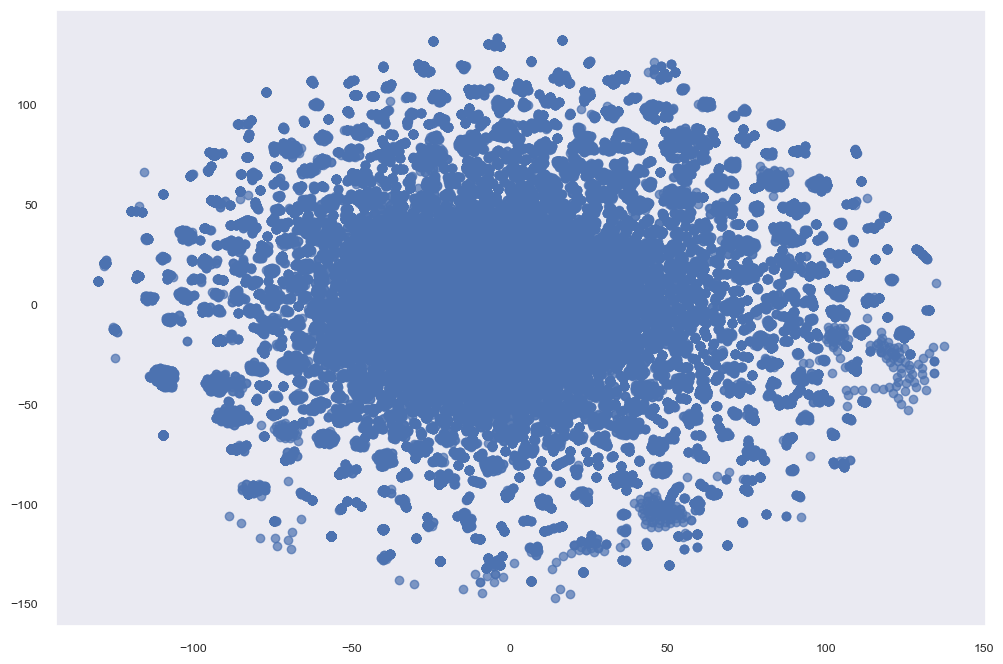

In [48]:
%%time
tsne = TSNE(n_components=2, random_state=33)
T = tsne.fit_transform(scaled_emb)

plt.figure(figsize=(12,8))
plt.scatter(T[:,0], T[:,1], alpha=0.7)
plt.grid()

In [ ]:
%%time
mds_trans = MDS(n_components=2, random_state=33)
M = mds_trans.fit_transform(scaled_emb)

plt.figure(figsize=(12,8))
plt.scatter(M[:,0], M[:,1], alpha=0.7)
plt.grid()